# Poisson Matrix Factorization

Disclaimer: these are non-sparse implementations.They can be optimized.

In [3]:
# import libraries
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
from scipy.stats import gamma, poisson
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import matplotlib

import functions as fun

In [4]:
prng = np.random.RandomState(10)  # container for the Mersenne Twister pseudo-random number generator
cmap = matplotlib.cm.get_cmap('tab20')  # colormap

### Pre-Processing

In [5]:
# import dataset
graph = nx.read_gml('football/football_net.gml')
# keep largest connected component
Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
graph = graph.subgraph(Gcc[0])

print('nodes N =',graph.number_of_nodes(),'\nedges E =',graph.number_of_edges())

nodes N = 115 
edges E = 613


In [6]:
# import dataset covariates to create ground truth
df = pd.read_csv('football/football_cov.csv')
ground_lab = ['Atlantic Coast','Big East','Big Ten','Big Twelve','Conference USA','Big West','Mid-American',
              'Mountain West','Pacific Ten','Southeastern','Western Athletic','NotreDame','Navy','Connecticut',
              'CentralFlorida','Middle Tennessee State','LouisianaTech','LouisianaMonroe','LouisianaLafayette']
ground_truth = {}
for i,j in enumerate(ground_lab):
    ground_truth[i] = list(df[df.conference==j].index)
K = len(ground_truth)

print('communities K =', K)

communities K = 19


In [7]:
df.head(2)
# the ground_truth is given by the conference

,names,metadata,conference
0,BrighamYoung,7,Mountain West
1,FloridaState,0,Atlantic Coast


In [8]:
ground_truth

{0: [1, 25, 33, 37, 45, 89, 103, 105, 109],
 1: [19, 29, 30, 35, 55, 79, 94, 101],
 2: [2, 6, 13, 15, 32, 39, 47, 60, 64, 100, 106],
 3: [3, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107],
 4: [44, 48, 57, 66, 75, 86, 91, 92, 112],
 5: [11, 24, 28, 50, 69, 90],
 6: [12, 14, 18, 26, 31, 34, 38, 43, 54, 61, 71, 85, 99],
 7: [0, 4, 9, 16, 23, 41, 93, 104],
 8: [7, 8, 21, 22, 51, 68, 77, 78, 108, 111],
 9: [17, 20, 27, 56, 62, 65, 70, 76, 87, 95, 96, 113],
 10: [46, 49, 53, 67, 73, 83, 88, 110, 114],
 11: [82],
 12: [80],
 13: [42],
 14: [36],
 15: [63],
 16: [58],
 17: [59],
 18: [97]}

In [9]:
# defrozen graph and make directed
graph = nx.DiGraph(graph)
print('nodes N =',graph.number_of_nodes(),'\nedges E =',graph.number_of_edges())

nodes N = 115 
edges E = 1226


In [10]:
# delete nodes belonging to communities having len=1
del_idx = []
for i in np.arange(11,19):
    for v in ground_truth[i]:
        n = df.iloc[v]['names']
        del_idx.append(v)
        graph.remove_node(n)
df.drop(del_idx, inplace=True)
df = df.reset_index()
A = nx.to_numpy_array(graph)  # save adjacency matrix
print('nodes N =', graph.number_of_nodes(),'\nedges E =', graph.number_of_edges())
print(df.shape)

nodes N = 107 
edges E = 1102
(107, 4)


In [9]:
# delete communities having len=1
ground_lab = ['Atlantic Coast','Big East','Big Ten','Big Twelve','Conference USA','Big West','Mid-American',
              'Mountain West','Pacific Ten','Southeastern','Western Athletic']
ground_truth = {}
for i,j in enumerate(ground_lab):
    ground_truth[i] = list(df[df.conference==j].index)
K = len(ground_truth)

print('communities K =', K)

communities K = 11


In [10]:
ground_truth

{0: [1, 25, 33, 36, 43, 82, 95, 97, 101],
 1: [19, 29, 30, 35, 53, 74, 87, 93],
 2: [2, 6, 13, 15, 32, 38, 45, 56, 59, 92, 98],
 3: [3, 5, 10, 39, 50, 67, 69, 75, 77, 90, 94, 99],
 4: [42, 46, 55, 61, 70, 79, 84, 85, 104],
 5: [11, 24, 28, 48, 64, 83],
 6: [12, 14, 18, 26, 31, 34, 37, 41, 52, 57, 66, 78, 91],
 7: [0, 4, 9, 16, 23, 40, 86, 96],
 8: [7, 8, 21, 22, 49, 63, 72, 73, 100, 103],
 9: [17, 20, 27, 54, 58, 60, 65, 71, 80, 88, 89, 105],
 10: [44, 47, 51, 62, 68, 76, 81, 102, 106]}

### Visualization of ground truth network

In [11]:
# communities per node
com = {}
for k in ground_truth:
    for v in ground_truth[k]:
        com[v] = k

In [12]:
node_size = [graph.degree[i]*17 for i in list(graph.nodes())]
position = nx.spring_layout(graph,iterations=200,seed=4)

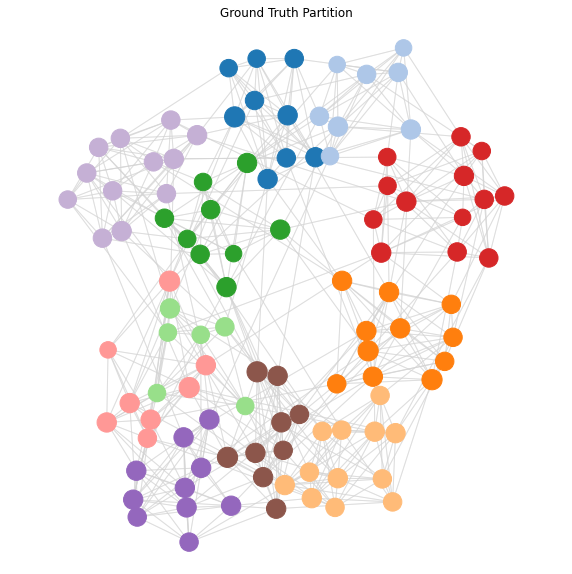

In [13]:
plt.figure(figsize=(10,10))
fun.plot_net_hard(graph, position, node_size, com, plt, cmap)
plt.title('Ground Truth Partition')
plt.show()

### Inference with EM

In [11]:
A = np.array([0, 1, 2])

B = np.array([[ 0,  1,  2,  3],
              [ 4,  5,  6,  7],
              [ 8,  9, 10, 11]])

In [14]:
A[:, np.newaxis]

array([[0],
       [1],
       [2]])

In [16]:
A[:, np.newaxis]*B 

array([[ 0,  0,  0,  0],
       [ 4,  5,  6,  7],
       [16, 18, 20, 22]])

In [19]:
B.sum(axis=0) # sum on axis i

array([12, 15, 18, 21])

In [20]:
B.sum(axis=1) # sum on axis j

array([ 6, 22, 38])

In [14]:
class PMF_EM(object):
    
    def __init__(self, A, K=3):
        self.A = A                 # data
        self.K = K                 # number of communities
        self.N = self.A.shape[0]   # number of nodes

    def _init(self, prng):
        self.u = prng.random_sample((self.N, self.K))
        self.v = prng.random_sample((self.N, self.K))
        self.C = prng.random_sample((self.K, self.K))
        
    def fit(self, prng, N_real=15, max_iter=100, tol=0.1, decision=2):
        maxL = - 1e12  # initialization of the maximum likelihood

        for r in range(N_real):
            # random initialization
            self._init(prng)
            
            # convergence local variables
            coincide, it = 0, 0
            convergence = False

            loglik_values = []  # keep track of the values of the loglik to plot
            loglik = - 1e12  # initialization of the loglik

            while not convergence and it < max_iter:
                self._em()
                it, loglik, coincide, convergence = self.check_for_convergence(it, loglik, coincide, convergence, tolerance=tol, decision=decision)
                loglik_values.append(loglik)
            print(f'Nreal = {r} - Loglikelihood = {fun.fl(loglik)} - Best Loglikelihood = {fun.fl(maxL)} - iterations = {it} - ')
    
            if maxL < loglik:
                u_f,v_f,C_f = self.update_optimal_parameters()
                maxL = loglik
                final_it = it
                best_loglik_values = list(loglik_values)
        
        return u_f, v_f, C_f, best_loglik_values

    def _em(self):
        # E-step
        q = self.update_q()
        # M-step
        self.u = self.update_u(q)
        q = self.update_q()
        self.v = self.update_v(q)
        q = self.update_q()
        self.C = self.update_C(q)

    def update_q(self):
        lambda_ij = np.einsum('ik,jq,kq-> ijkq', self.u, self.v, self.C)
        lambda_ij_den = np.einsum('ijkq -> ij', lambda_ij)
        return lambda_ij/lambda_ij_den[:,:,np.newaxis,np.newaxis]
    
    def update_u(self, q):
        numerator = np.einsum('ij,ijkq->ik', self.A, q)
        denominator = np.einsum('q,kq->k', self.v.sum(axis=0), self.C)[np.newaxis,:]
        u_temp = numerator / denominator
        return u_temp

    def update_v(self, q):
        numerator = np.einsum('ij,ijkq->jq', self.A, q)
        denominator = np.einsum('k,kq->q', self.u.sum(axis=0), self.C)[np.newaxis,:]
        v_temp = numerator / denominator
        return v_temp

    def update_C(self, q):
        numerator = np.einsum('ij,ijkq->kq', self.A, q)
        denominator = np.einsum('k,q->kq', self.u.sum(axis=0), self.v.sum(axis=0))
        C_temp = numerator / denominator
        return C_temp
    
    def check_for_convergence(self, it, loglik, coincide, convergence, tolerance=0.1, decision=2):
        if it % 10 == 0:
            old_L = loglik
            loglik = self.Likelihood(EPS = 1e-12)
            if abs(loglik - old_L) < tolerance:
                coincide += 1
            else:
                coincide = 0
        if coincide > decision:
            convergence = True
        it += 1
        return it, loglik, coincide, convergence

    def Likelihood(self, EPS = 1e-12):
        lambda_ij = np.einsum('ik,jq,kq-> ij', self.u, self.v, self.C)
        return (self.A * np.log(lambda_ij + EPS)).sum() - lambda_ij.sum() 

    def update_optimal_parameters(self):
        u_f = np.copy(self.u)
        v_f = np.copy(self.v)
        C_f = np.copy(self.C)
        return u_f,v_f,C_f

In [15]:
pmf_em = PMF_EM(A, K=K)
u_em, v_em, C_em, best_loglik_values = pmf_em.fit(prng)

Nreal = 0 - Loglikelihood = -2171.7 - Best Loglikelihood = -1000000000000.0 - iterations = 100 - 
Nreal = 1 - Loglikelihood = -2090.16 - Best Loglikelihood = -2171.7 - iterations = 100 - 
Nreal = 2 - Loglikelihood = -2014.35 - Best Loglikelihood = -2090.16 - iterations = 100 - 
Nreal = 3 - Loglikelihood = -2106.92 - Best Loglikelihood = -2014.35 - iterations = 100 - 
Nreal = 4 - Loglikelihood = -2014.22 - Best Loglikelihood = -2014.35 - iterations = 100 - 
Nreal = 5 - Loglikelihood = -2148.81 - Best Loglikelihood = -2014.22 - iterations = 100 - 
Nreal = 6 - Loglikelihood = -2045.72 - Best Loglikelihood = -2014.22 - iterations = 100 - 
Nreal = 7 - Loglikelihood = -2126.63 - Best Loglikelihood = -2014.22 - iterations = 100 - 
Nreal = 8 - Loglikelihood = -2222.99 - Best Loglikelihood = -2014.22 - iterations = 100 - 
Nreal = 9 - Loglikelihood = -2008.98 - Best Loglikelihood = -2014.22 - iterations = 100 - 
Nreal = 10 - Loglikelihood = -1996.83 - Best Loglikelihood = -2008.98 - iterations =

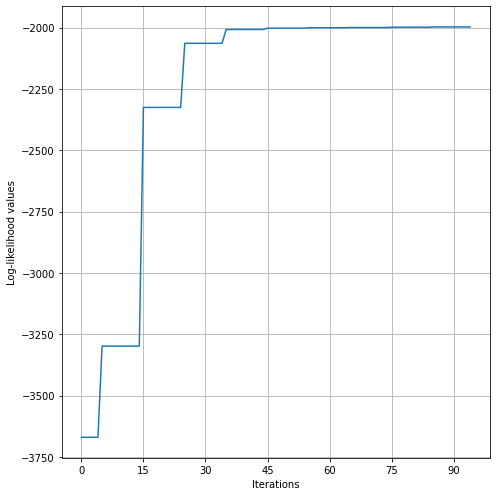

In [16]:
fun.plot_L(best_loglik_values, int_ticks=True)

#### Plot results

In [17]:
u_norm_em = fun.normalize_nonzero_membership(u_em)
v_norm_em = fun.normalize_nonzero_membership(v_em)

q_em = np.argmax(u_norm_em, axis=1)  # extract hard communities

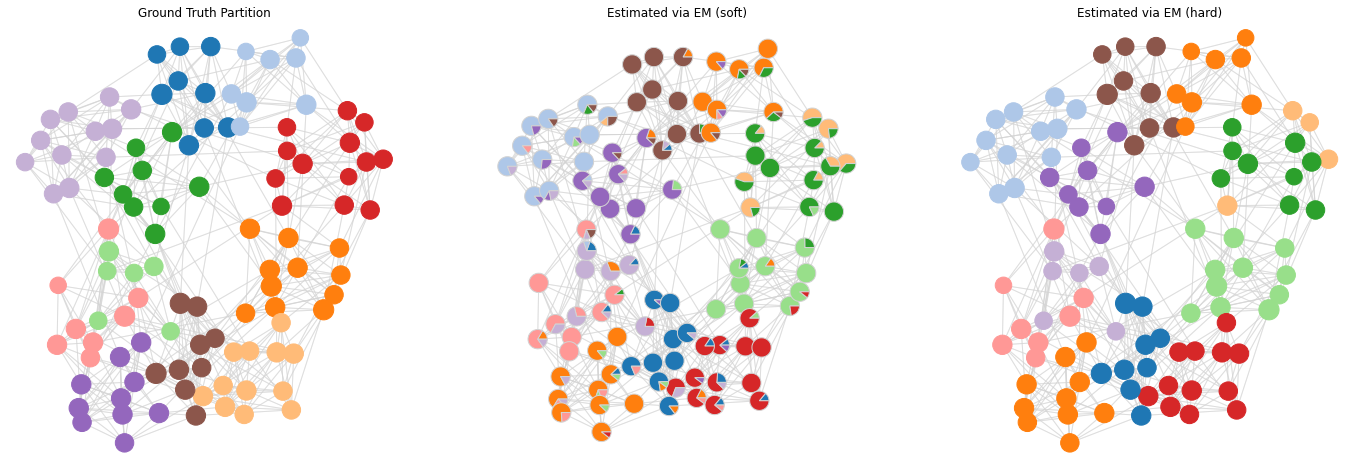

In [18]:
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
fun.plot_net_hard(graph, position, node_size, com, plt, cmap)
plt.title('Ground Truth Partition')
plt.subplot(1,3,2)
fun.plot_net_over(graph, position, u_norm_em, plt, cmap)
plt.title('Estimated via EM (soft)')
plt.subplot(1,3,3)
fun.plot_net_hard(graph, position, node_size, q_em, plt, cmap)
plt.title('Estimated via EM (hard)')
plt.show()

In [19]:
# change labelling
u_em_lab = u_norm_em[:, [10,3,5,6,8,9,4,7,2,1,0]]
q_em = np.argmax(u_em_lab, axis=1)

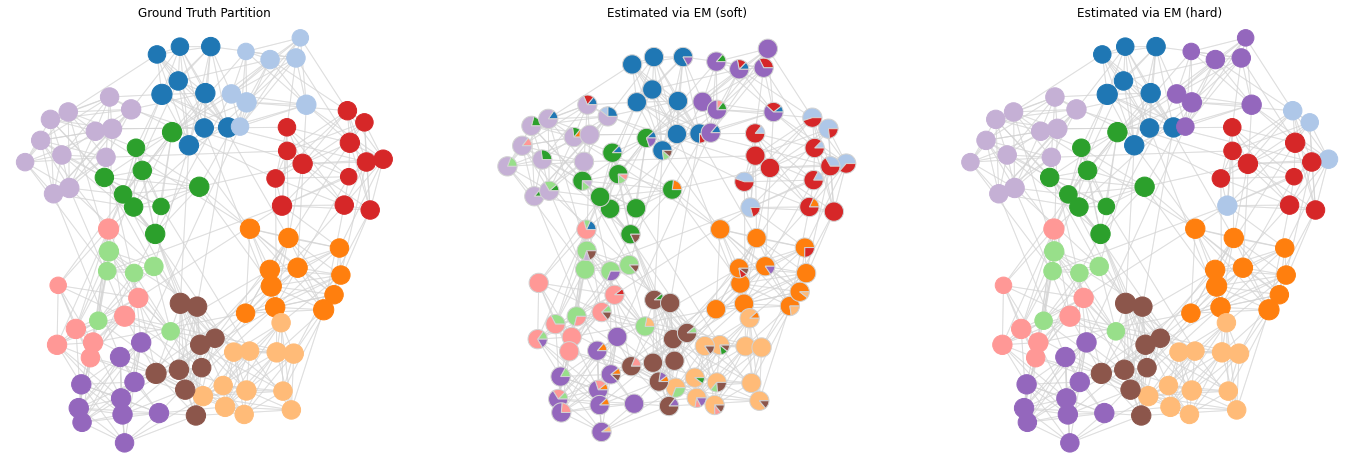

In [20]:
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
fun.plot_net_hard(graph, position, node_size, com, plt, cmap)
plt.title('Ground Truth Partition')
plt.subplot(1,3,2)
fun.plot_net_over(graph, position, u_em_lab, plt, cmap)
plt.title('Estimated via EM (soft)')
plt.subplot(1,3,3)
fun.plot_net_hard(graph, position, node_size, q_em, plt, cmap)
plt.title('Estimated via EM (hard)')
plt.show()

### Inference with VI

In [21]:
class PMF_VI(object):
    
    def __init__(self, A, K=3):
        self.A = A                 # data
        self.K = K                 # number of communities
        self.N = self.A.shape[0]   # number of nodes

    def _init(self, prng):
        # priors
        self.a = 1
        self.b = 1
        self.c = 1
        self.d = 1
        
        # random initialization
        self.alpha_shp = prng.random_sample(size=(self.N,self.K)) + self.a
        self.alpha_rte = prng.random_sample(size=(self.N,self.K)) + self.b
        self.beta_shp = prng.random_sample(size=(self.N,self.K)) + self.c
        self.beta_rte = prng.random_sample(size=(self.N,self.K)) + self.d

    def fit(self, prng, N_real=15, max_iter=100, tol=0.1, decision=2):
        maxElbo = - 1e12  # initialization of the maximum elbo

        for r in range(N_real):
            # random initialization
            self._init(prng)

            # convergence local variables
            coincide, it = 0, 0
            convergence = False

            elbo_values = []  # keep track of the values of the elbo to plot
            elbo = - 1e12  # initialization of the loglik

            while not convergence and it < max_iter:
                self._cavi()
                
                Eu, Elogu = compute_expectations(self.alpha_shp, self.alpha_rte)
                Ev, Elogv = compute_expectations(self.beta_shp, self.beta_rte)

                it, elbo, coincide, convergence = self.check_for_convergence_cavi(Eu, Elogu, Ev, Elogv, it, elbo, coincide,   
                                                                          convergence, tolerance=tol, decision=decision)
                elbo_values.append(elbo)
            print(f'Nreal = {r} - ELBO = {fun.fl(elbo)} - Best ELBO = {fun.fl(maxElbo)} - iterations = {it} - ')

            if maxElbo < elbo:
                alpha_shp_f,alpha_rte_f,beta_shp_f,beta_rte_f = self.update_optimal_parameters()
                maxElbo = elbo
                final_it = it
                best_elbo_values = list(elbo_values)
        
        return alpha_shp_f, alpha_rte_f, beta_shp_f, beta_rte_f, best_elbo_values

    def _cavi(self):
        phi_ij = self.update_phi()

        self.update_alphas(phi_ij)
        phi_ij = self.update_phi()
        self.update_betas(phi_ij)

    def update_phi(self):
        phi_ijk = np.einsum('ik,jk->ijk',np.exp(sp.psi(self.alpha_shp) - np.log(self.alpha_rte)), np.exp(sp.psi(self.beta_shp) - np.log(self.beta_rte)))
        sumPhi = phi_ijk.sum(axis=-1)[:,:,np.newaxis]
        sumPhi[sumPhi == 0] = 1
        return phi_ijk / sumPhi
    
    def update_alphas(self, phi_ij):
        self.alpha_shp = self.a + np.einsum('ij,ijk->ik', self.A,phi_ij)
        self.alpha_rte = self.b + (self.beta_shp / self.beta_rte).sum(axis=0)[np.newaxis,:]
        
    def update_betas(self, phi_ij):
        self.beta_shp = self.c + np.einsum('ij,ijk->jk', self.A,phi_ij)
        self.beta_rte = self.d + (self.alpha_shp / self.alpha_rte).sum(axis=0)[np.newaxis,:]
   
    def check_for_convergence_cavi(self, Eu, Elogu, Ev, Elogv, it, elbo, coincide, convergence, tolerance=0.1,decision=2):
        if it % 10 == 0:
            old_elbo = elbo
            elbo = self.Elbo(Eu, Elogu, Ev, Elogv)
            if abs(elbo - old_elbo) < tolerance:
                coincide += 1
            else:
                coincide = 0
        if coincide > decision:
            convergence = True
        it += 1
        return it, elbo, coincide, convergence

    def Elbo(self, Eu, Elogu, Ev, Elogv):
        bound = (self.A * np.log(np.einsum('ik,jk->ij',np.exp(Elogu),np.exp(Elogv)))).sum() - Eu.dot(Ev.T).sum()
        bound += gamma_elbo_term(pa=self.a, pb=self.b, qa=self.alpha_shp, qb=self.alpha_rte).sum()
        bound += gamma_elbo_term(pa=self.c, pb=self.d, qa=self.beta_shp, qb=self.beta_rte).sum()
        return bound

    def update_optimal_parameters(self):
        alpha_shp = np.copy(self.alpha_shp)
        alpha_rte = np.copy(self.alpha_rte)
        beta_shp = np.copy(self.beta_shp)
        beta_rte = np.copy(self.beta_rte)
        return alpha_shp,alpha_rte,beta_shp,beta_rte
    
def compute_expectations(alpha, beta):
    '''
    Given x ~ Gam(alpha, beta), compute E[x] and E[log x]
    '''    
    return (alpha / beta , sp.psi(alpha) - np.log(beta))

def gamma_elbo_term(pa, pb, qa, qb):
        return sp.gammaln(qa) - pa * np.log(qb) + (pa - qa) * sp.psi(qa) + qa * (1 - pb / qb)

In [22]:
pmf_vi = PMF_VI(A, K=K)
alpha_shp_vi, alpha_rte_vi, beta_shp_vi, beta_rte_vi, best_elbo_values = pmf_vi.fit(prng)

Nreal = 0 - ELBO = -7236.26 - Best ELBO = -1000000000000.0 - iterations = 71 - 
Nreal = 1 - ELBO = -7233.55 - Best ELBO = -7236.26 - iterations = 61 - 
Nreal = 2 - ELBO = -7229.81 - Best ELBO = -7233.55 - iterations = 81 - 
Nreal = 3 - ELBO = -7244.35 - Best ELBO = -7229.81 - iterations = 61 - 
Nreal = 4 - ELBO = -7273.48 - Best ELBO = -7229.81 - iterations = 61 - 
Nreal = 5 - ELBO = -7249.0 - Best ELBO = -7229.81 - iterations = 71 - 
Nreal = 6 - ELBO = -7252.36 - Best ELBO = -7229.81 - iterations = 61 - 
Nreal = 7 - ELBO = -7262.28 - Best ELBO = -7229.81 - iterations = 71 - 
Nreal = 8 - ELBO = -7234.41 - Best ELBO = -7229.81 - iterations = 71 - 
Nreal = 9 - ELBO = -7242.88 - Best ELBO = -7229.81 - iterations = 91 - 
Nreal = 10 - ELBO = -7249.0 - Best ELBO = -7229.81 - iterations = 71 - 
Nreal = 11 - ELBO = -7239.79 - Best ELBO = -7229.81 - iterations = 71 - 
Nreal = 12 - ELBO = -7267.16 - Best ELBO = -7229.81 - iterations = 61 - 
Nreal = 13 - ELBO = -7237.99 - Best ELBO = -7229.81 - i

In [23]:
Eu_vi, Elogu_vi = compute_expectations(alpha_shp_vi,alpha_rte_vi)
Ev_vi, Elogv_vi = compute_expectations(beta_shp_vi,beta_rte_vi)

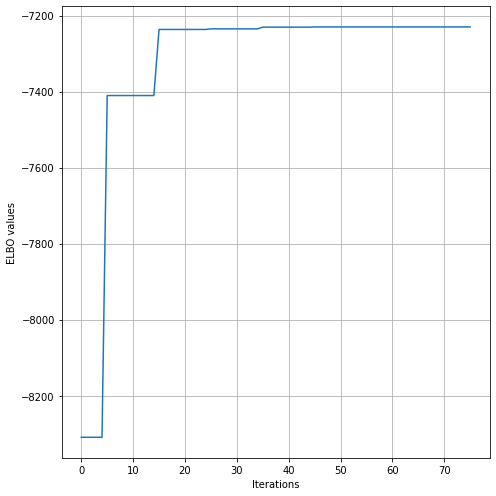

In [24]:
fun.plot_L(best_elbo_values, int_ticks=True, ylab='ELBO')

#### Plot results

In [25]:
u_norm_vi = fun.normalize_nonzero_membership(Eu_vi)
v_norm_vi = fun.normalize_nonzero_membership(Ev_vi)

q_vi = np.argmax(u_norm_vi, axis=1)  # extract hard communities

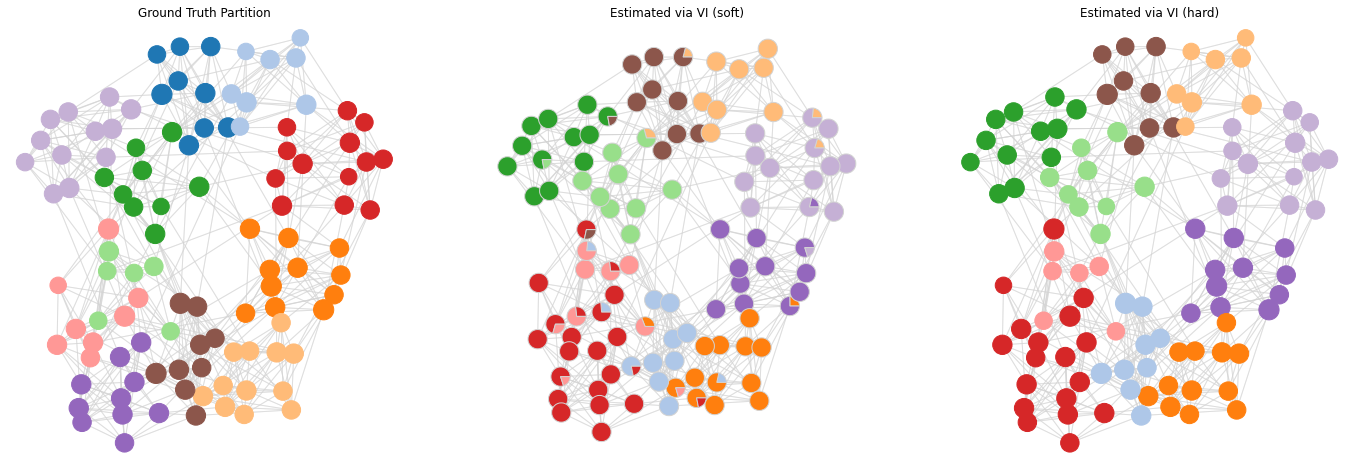

In [26]:
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
fun.plot_net_hard(graph, position, node_size, com, plt, cmap)
plt.title('Ground Truth Partition')
plt.subplot(1,3,2)
fun.plot_net_over(graph, position, u_norm_vi, plt, cmap)
plt.title('Estimated via VI (soft)')
plt.subplot(1,3,3)
fun.plot_net_hard(graph, position, node_size, q_vi, plt, cmap)
plt.title('Estimated via VI (hard)')
plt.show()

In [27]:
# change labelling
u_vi_lab = u_norm_vi[:, [10,3,8,2,5,7,9,0,6,4,1]]
q_vi = np.argmax(u_vi_lab, axis=1)

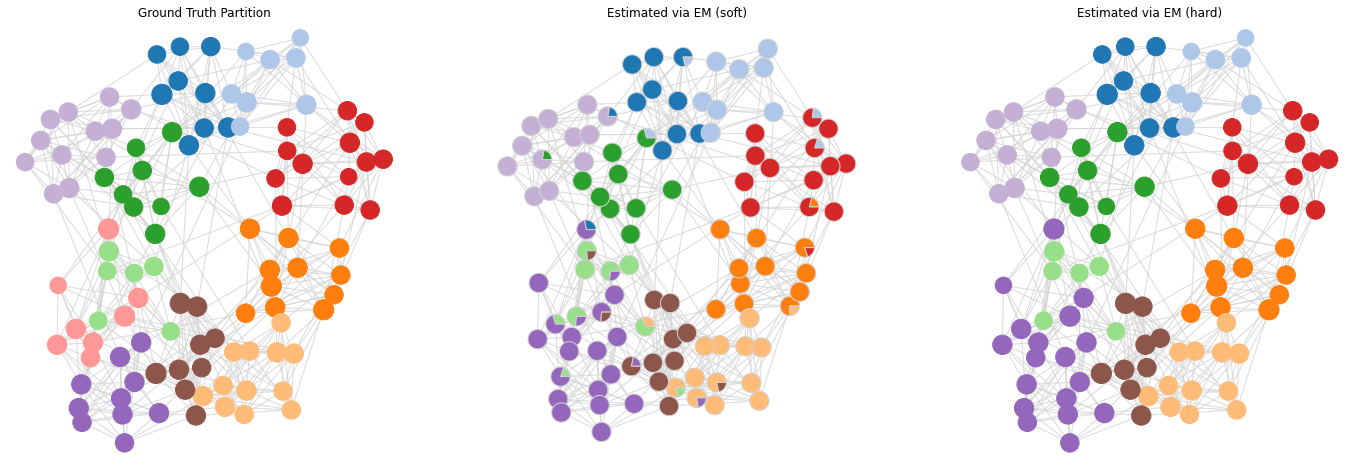

In [28]:
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
fun.plot_net_hard(graph, position, node_size, com, plt, cmap)
plt.title('Ground Truth Partition')
plt.subplot(1,3,2)
fun.plot_net_over(graph, position, u_vi_lab, plt, cmap)
plt.title('Estimated via EM (soft)')
plt.subplot(1,3,3)
fun.plot_net_hard(graph, position, node_size, q_vi, plt, cmap)
plt.title('Estimated via EM (hard)')
plt.show()

#### Plot results: GT - EM - VI

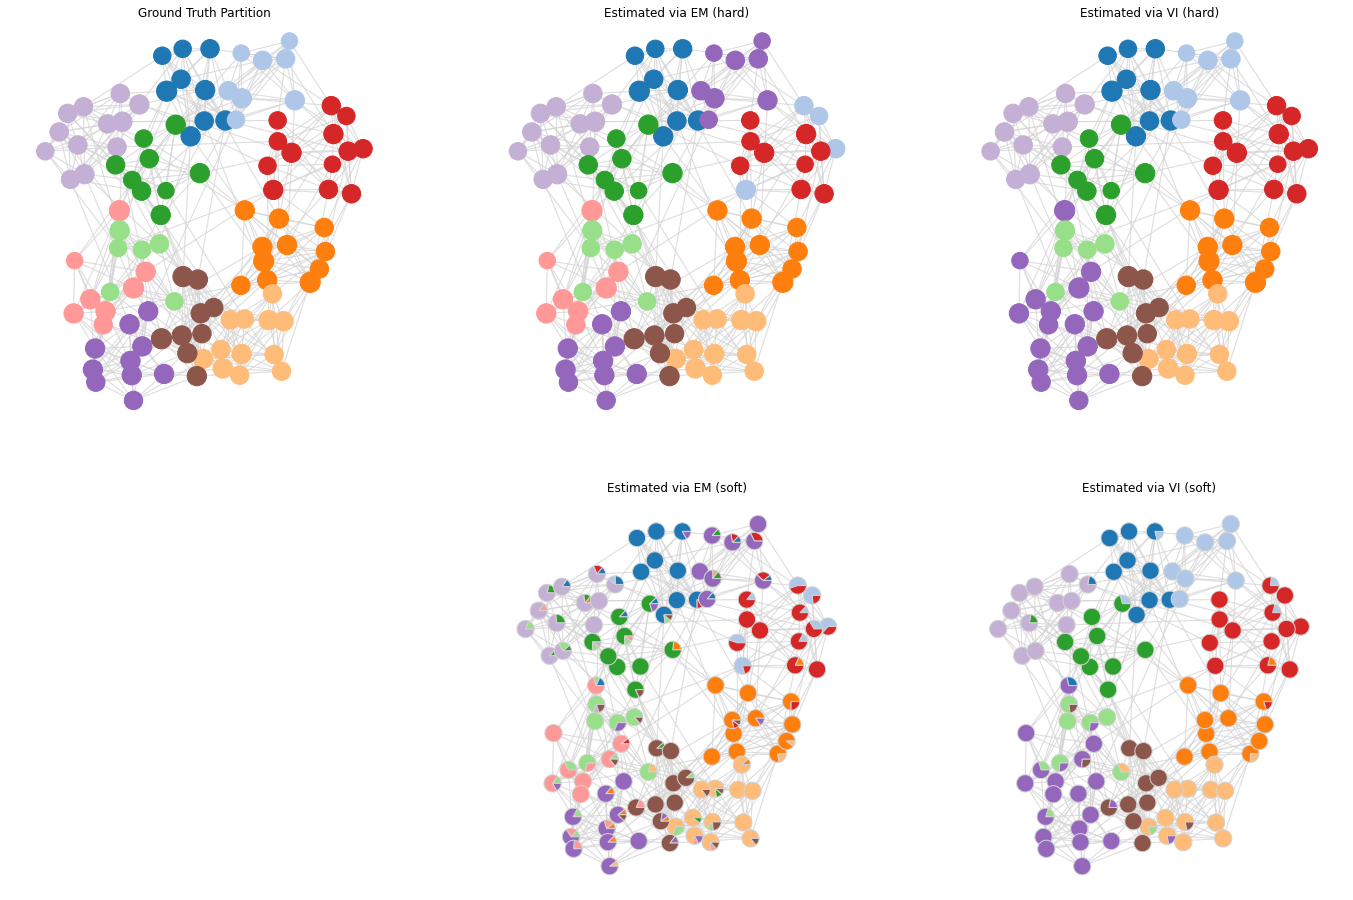

In [29]:
plt.figure(figsize=(24,16))
plt.subplot(2,3,1)
fun.plot_net_hard(graph, position, node_size, com, plt, cmap)
plt.title('Ground Truth Partition')
plt.subplot(2,3,2)
fun.plot_net_hard(graph, position, node_size, q_em, plt, cmap)
plt.title('Estimated via EM (hard)')
plt.subplot(2,3,3)
fun.plot_net_hard(graph, position, node_size, q_vi, plt, cmap)
plt.title('Estimated via VI (hard)')
plt.subplot(2,3,5)
fun.plot_net_over(graph, position, u_em_lab, plt, cmap)
plt.title('Estimated via EM (soft)')
plt.subplot(2,3,6)
fun.plot_net_over(graph, position, u_vi_lab, plt, cmap)
plt.title('Estimated via VI (soft)')
plt.show()